In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import datetime

In [ ]:
# 不想訓練，可以直接到最下面load model

In [3]:
# 導入資料，適用於沒有digitize字樣的資料(有用帶sec字樣的資料，要改model)
data = pd.read_csv('dataset/testset.csv')
data.head()

,gender,points,badges_cnt,user_grade,user_city,has_teacher_cnt,is_self_coach,has_student_cnt,belongs_to_class_cnt,has_class_cnt,is_correct
0,no_value,18300,1,1,kh,0,0,0,0,0,0.894737
1,no_value,6468,0,1,ntpc,1,0,0,1,0,0.722222
2,male,4703,0,1,tp,0,0,0,0,0,0.857143
3,no_value,15525,1,2,ntpc,0,0,0,0,0,0.866667
4,no_value,7945,0,2,km,1,0,0,1,0,0.750000


In [5]:
# 拆分資料集 81%訓練 9%驗證 10%測試
train, test = train_test_split(data, test_size=0.1)
train, val = train_test_split(train, test_size=0.1)

In [6]:
# 設定資料集，轉換成tf.data.Dataset
def df_to_dataset(dataframe, shuffle=True, batch_size=32):

    dataframe = dataframe.copy()

    labels = dataframe.pop("is_correct")

    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))

    if shuffle:

        ds = ds.shuffle(buffer_size=len(dataframe))

    ds = ds.batch(batch_size=batch_size)

    return ds

In [7]:
# 設定資料集(tf.data.Dataset)
batch_size = 64
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [8]:
# 純數字的輸入層
def get_normalization_layer(name, dataset):
    normalizer = layers.Normalization(axis=None)
    feature_ds = dataset.map(lambda x, y: x[name])
    normalizer.adapt(feature_ds)
    return normalizer

In [9]:
# 類別的輸入層(像年級、有無特殊屬性的布林值)
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)
    feature_ds = dataset.map(lambda x, y: x[name])
    index.adapt(feature_ds)
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())
    embedding = layers.Embedding(index.vocabulary_size(), 4)
    mask = layers.GlobalMaxPool1D()
    return lambda feature: mask(embedding(encoder(index(feature))))

In [10]:
# 設定純數字的輸入層，要加sec要改這裡(加入"total_sec_taken"到for迴圈的list)
all_input = []
encoded_features = []

for header in [
    "points",
    "badges_cnt",
    "has_teacher_cnt",
    "has_student_cnt",
    "belongs_to_class_cnt",
    "has_class_cnt",
    # "total_sec_taken",
]:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_input.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

In [11]:
# 設定數字類別的輸入層
for header in ['user_grade', 'is_self_coach']:
    grade = tf.keras.Input(shape=(1,), name=header, dtype='int64')
    encoding_layer = get_category_encoding_layer(header, train_ds, dtype='int64', max_tokens=12)
    encoded_grade = encoding_layer(grade)
    all_input.append(grade)
    encoded_features.append(encoded_grade)

In [12]:
# 設定文字類別的輸入層
category_cols = ["user_city", "gender"]
for header in category_cols:
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string', max_tokens=30)
    encoded_categorical_col = encoding_layer(categorical_col)
    all_input.append(categorical_col)
    encoded_features.append(encoded_categorical_col)

In [22]:
# 設定 Model 的 hidden layers
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(1)(x)

In [23]:
model = tf.keras.Model(all_input, output)

In [24]:
# 設定 Model 的 optimizer, loss function, metrics
model.compile(optimizer='adam',
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=['accuracy'])

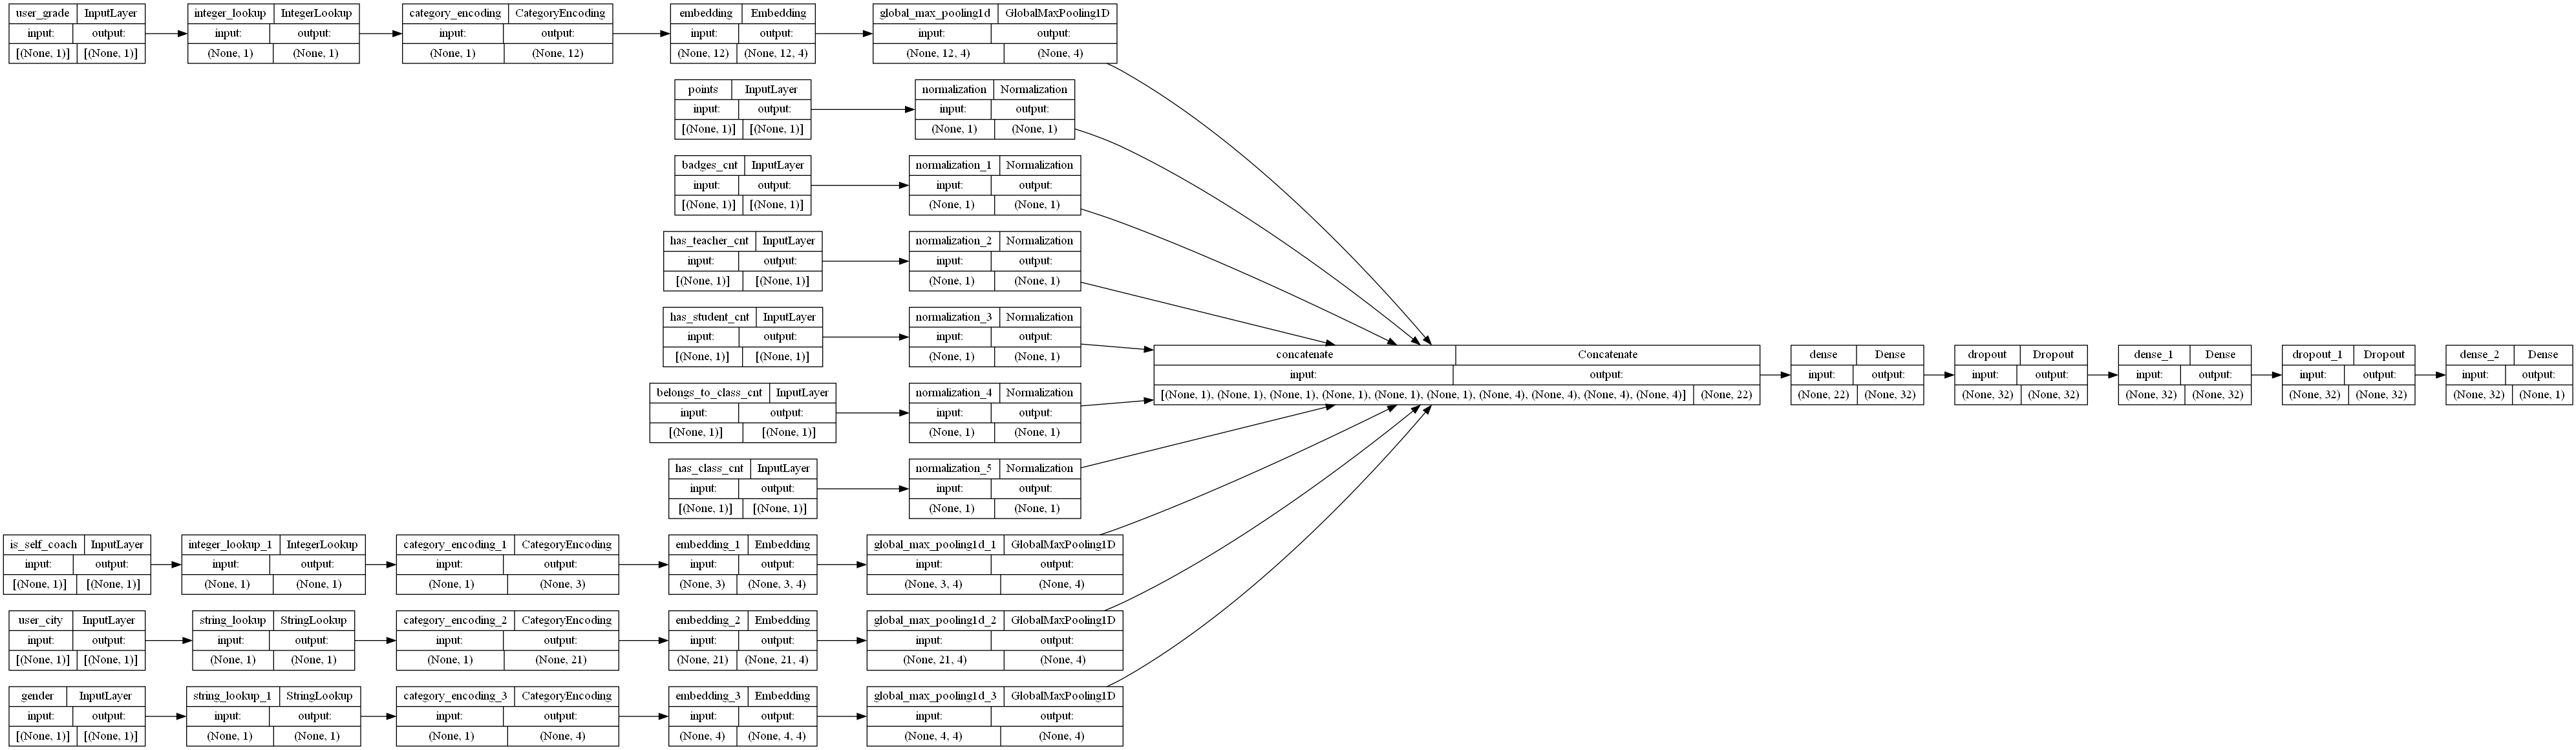

In [16]:
# 顯示 Model 的架構
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [25]:
# 設定 tensorboard(訓練的log)
log_dir = "logs/dataset_fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [26]:
# 訓練 Model
model.fit(train_ds, epochs=300, validation_data=val_ds, callbacks=[tensorboard_callback])

Epoch 1/300


d:\Python\Python39\lib\site-packages\keras\engine\functional.py:637: UserWarning: Input dict contained keys ['Unnamed: 0'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


417/417 [==============================] - 9s 19ms/step - loss: 0.1339 - accuracy: 0.0381 - val_loss: 0.0439 - val_accuracy: 0.0392
Epoch 2/300
417/417 [==============================] - 7s 16ms/step - loss: 0.0555 - accuracy: 0.0419 - val_loss: 0.0348 - val_accuracy: 0.0395
Epoch 3/300
417/417 [==============================] - 7s 16ms/step - loss: 0.0476 - accuracy: 0.0420 - val_loss: 0.0330 - val_accuracy: 0.0395
Epoch 4/300
417/417 [==============================] - 7s 17ms/step - loss: 0.0406 - accuracy: 0.0424 - val_loss: 0.0320 - val_accuracy: 0.0395
Epoch 5/300
417/417 [==============================] - 7s 15ms/step - loss: 0.0369 - accuracy: 0.0425 - val_loss: 0.0311 - val_accuracy: 0.0395
Epoch 6/300
417/417 [==============================] - 6s 15ms/step - loss: 0.0365 - accuracy: 0.0425 - val_loss: 0.0299 - val_accuracy: 0.0392
Epoch 7/300
417/417 [==============================] - 7s 18ms/step - loss: 0.0339 - accuracy: 0.0425 - val_loss: 0.0294 - val_accuracy: 0.0392
Epoc

In [27]:
# 用 test 資料集評估 Model
loss, accuracy = model.evaluate(test_ds)

52/52 [==============================] - 1s 9ms/step - loss: 0.0270 - accuracy: 0.0489


In [6]:
# 儲存 Model
# model.save("model.tf", save_format="tf")

In [7]:
# 載入 Model(不適用於有 "total_sec_taken" 的資料)
# model = tf.keras.models.load_model('model.tf')

In [4]:
# 用 test 資料集評估載入的 Model
# model.evaluate(test_ds)

In [10]:
# ans = 0.894737
sample = {
    "gender": "no_value",
    "points": 18300,
    "badges_cnt": 1,
    "user_grade": 1,
    "user_city": "kh",
    "has_teacher_cnt": 0,
    "is_self_coach": 0,
    "has_student_cnt": 0,
    "belongs_to_class_cnt": 0,
    "has_class_cnt": 0,
    # "total_sec_taken": 37.842105,
}

In [28]:
sample2 = {
    "gender": "male",
    "points": 9075,
    "badges_cnt": 9,
    "user_grade": 7,
    "user_city": "kh",
    "has_teacher_cnt": 3,
    "is_self_coach": 0,
    "has_student_cnt": 0,
    "belongs_to_class_cnt": 3,
    "has_class_cnt": 0,
    # "total_sec_taken": 37.842105,
}

In [11]:
# 預測單筆資料
input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
pred = model.predict(input_dict)
print(pred)

1/1 [==============================] - 1s 803ms/step
[[0.81140494]]
